<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/VErho_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

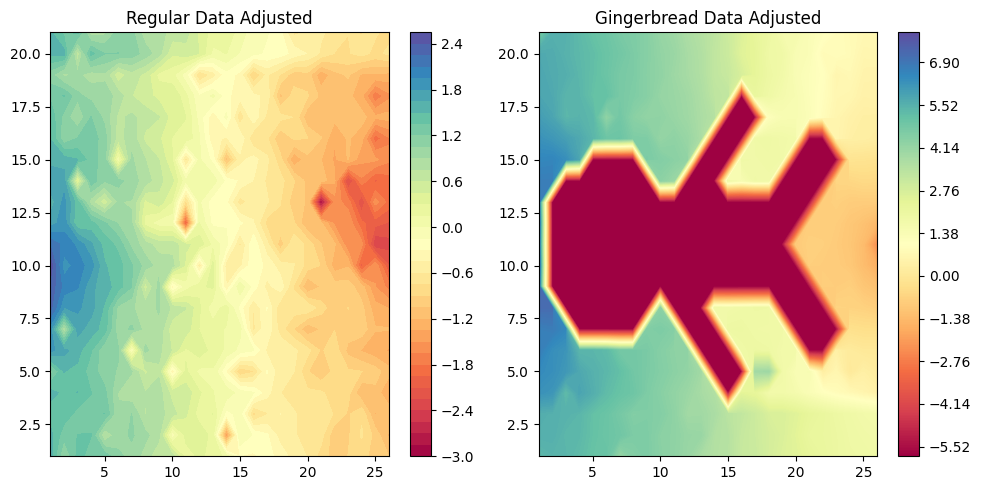

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

#--- Helper to read, flip, transpose, and build interpolator ---#
def build_interpolator(filename):
    df = pd.read_excel(filename, header=None)
    # In Mathematica: Transpose[Reverse[data]]
    # => flip vertically (flipud), then transpose in Python
    arr = np.flipud(df.values).T
    nx, ny = arr.shape
    x_range = np.arange(1, nx+1)
    y_range = np.arange(1, ny+1)
    interpolator = RegularGridInterpolator((x_range, y_range), arr, method='linear')
    return interpolator, (nx, ny)

#--- Compute offset by averaging over a band around midpoint in x ---#
def compute_offset(interpolator, dims, band_width=5):
    nx, ny = dims
    mid_x = nx / 2
    xs = range(int(mid_x - band_width), int(mid_x + band_width + 1))
    ys = range(1, ny + 1)
    vals = []
    for x in xs:
        for y in ys:
            # Interpolator expects (x, y) in domain
            vals.append(interpolator((x, y)))
    return np.mean(vals)

#--- Read & process Regular data ---#
VsmoothRegular, dimsRegular = build_interpolator("/content/Regular.xlsx")
offsetRegular = compute_offset(VsmoothRegular, dimsRegular, band_width=5)

# Evaluate adjusted data on full domain
nxR, nyR = dimsRegular
xR = np.arange(1, nxR+1)
yR = np.arange(1, nyR+1)
Xr, Yr = np.meshgrid(xR, yR, indexing='ij')
Zr = np.zeros_like(Xr, dtype=float)
for i in range(nxR):
    for j in range(nyR):
        Zr[i,j] = VsmoothRegular((xR[i], yR[j])) - offsetRegular

#--- Read & process Gingerbread data ---#
VsmoothGinger, dimsGinger = build_interpolator("/content/Gingerbread.xlsx")
offsetGinger = compute_offset(VsmoothGinger, dimsGinger, band_width=5)

nxG, nyG = dimsGinger
xG = np.arange(1, nxG+1)
yG = np.arange(1, nyG+1)
Xg, Yg = np.meshgrid(xG, yG, indexing='ij')
Zg = np.zeros_like(Xg, dtype=float)
for i in range(nxG):
    for j in range(nyG):
        Zg[i,j] = VsmoothGinger((xG[i], yG[j])) - offsetGinger

#--- Plot side-by-side ---#
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

c1 = axes[0].contourf(Xr, Yr, Zr, levels=50, cmap='Spectral')
axes[0].set_title("Regular Data Adjusted")
fig.colorbar(c1, ax=axes[0])

c2 = axes[1].contourf(Xg, Yg, Zg, levels=50, cmap='Spectral')
axes[1].set_title("Gingerbread Data Adjusted")
fig.colorbar(c2, ax=axes[1])

plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

########################
# 1. Read and Process Data
########################

def load_and_interpolate(filename):
    """
    Reads the Excel file, flips and transposes to match
    Mathematica's Transpose[Reverse[...]] operation,
    and sets up a RegularGridInterpolator with domain
    centered at (0,0).
    """
    df = pd.read_excel(filename, header=None)
    # Flip vertically (np.flipud) then transpose
    arr = np.flipud(df.values).T
    nx, ny = arr.shape

    # Create "centered" coordinate arrays:
    # x in [-nx/2, +nx/2], y in [-ny/2, +ny/2]
    # So index i => x[i] = i - nx/2 (similarly for y)
    x_vals = np.arange(nx) - (nx/2.0)
    y_vals = np.arange(ny) - (ny/2.0)

    # Build interpolator
    interpolator = RegularGridInterpolator((x_vals, y_vals), arr, method='linear')
    return interpolator, (nx, ny)

regular_interp, dims_reg = load_and_interpolate("/content/Regular.xlsx")
ginger_interp, dims_ging = load_and_interpolate("/content/Gingerbread.xlsx")

########################
# 2. Make Contour Plots of Measured Data
########################

def eval_on_grid(interp, dims, N=100):
    """
    Evaluate the interpolation on a meshgrid
    covering the full domain in a 'centered' way.
    N controls resolution of the output grid.
    """
    nx, ny = dims
    x_min, x_max = -(nx/2.0), (nx/2.0)
    y_min, y_max = -(ny/2.0), (ny/2.0)

    x_grid = np.linspace(x_min, x_max, N)
    y_grid = np.linspace(y_min, y_max, N)
    X, Y = np.meshgrid(x_grid, y_grid, indexing='xy')

    # Evaluate potential
    V = np.zeros_like(X)
    for i in range(N):
        for j in range(N):
            V[i,j] = interp((X[i,j], Y[i,j]))
    return X, Y, V

Xr, Yr, Vr = eval_on_grid(regular_interp, dims_reg, N=200)
Xg, Yg, Vg = eval_on_grid(ginger_interp, dims_ging, N=200)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
c1 = axes[0].contourf(Xr, Yr, Vr, levels=50, cmap='Spectral')
axes[0].set_title("Contour: Regular Data (Centered)")
fig.colorbar(c1, ax=axes[0])

c2 = axes[1].contourf(Xg, Yg, Vg, levels=50, cmap='Spectral')
axes[1].set_title("Contour: Gingerbread Data (Centered)")
fig.colorbar(c2, ax=axes[1])
plt.tight_layout()
plt.show()

########################
# 3. Stream Plots of the Electric Field
########################

def compute_field(interp, dims, N=30):
    """
    Numerically approximate the electric field
    E = -grad(V) on a coarse grid for streamplot.
    """
    nx, ny = dims
    x_min, x_max = -(nx/2.0), (nx/2.0)
    y_min, y_max = -(ny/2.0), (ny/2.0)

    x_grid = np.linspace(x_min, x_max, N)
    y_grid = np.linspace(y_min, y_max, N)
    X, Y = np.meshgrid(x_grid, y_grid, indexing='xy')

    # For finite differences
    dx = (x_max - x_min) / (N - 1)
    dy = (y_max - y_min) / (N - 1)

    Ex = np.zeros_like(X)
    Ey = np.zeros_like(X)

    for i in range(N):
        for j in range(N):
            x = X[i, j]
            y = Y[i, j]
            # Central difference for partial derivatives
            # Vx ~ [V(x+dx) - V(x-dx)]/(2*dx)
            # Vy ~ [V(x, y+dy) - V(x, y-dy)]/(2*dy)
            Vxp = interp((x + dx, y))
            Vxm = interp((x - dx, y))
            Vyp = interp((x, y + dy))
            Vym = interp((x, y - dy))

            dVdx = (Vxp - Vxm) / (2*dx)
            dVdy = (Vyp - Vym) / (2*dy)

            Ex[i, j] = -dVdx
            Ey[i, j] = -dVdy

    return X, Y, Ex, Ey

Xr_s, Yr_s, Exr, Eyr = compute_field(regular_interp, dims_reg, N=30)
Xg_s, Yg_s, Exg, Eyg = compute_field(ginger_interp, dims_ging, N=30)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].streamplot(Xr_s, Yr_s, Exr, Eyr, color='k', density=1)
axes[0].set_title("StreamPlot: Regular Data (Centered)")

axes[1].streamplot(Xg_s, Yg_s, Exg, Eyg, color='k', density=1)
axes[1].set_title("StreamPlot: Gingerbread Data (Centered)")

plt.tight_layout()
plt.show()

########################
# 4. Theoretical Expression (Dipole-like, Log form)
########################

def V_theoretical(x, y, a, Q=1, eps0=1):
    """
    Dipole-like potential in 2D:
    V = (Q / (4 pi eps0)) * log( ((x+a)^2 + y^2) / ((x-a)^2 + y^2) )
    """
    return (Q/(4.0*np.pi*eps0)) * np.log(((x+a)**2 + y**2)/((x-a)**2 + y**2))

# We'll use half the "width" from Regular data
nx_reg, ny_reg = dims_reg
a = nx_reg/2.0  # "half" the sheet width in the new centered coords

# Evaluate theoretical potential on the same domain as the regular data
N_theory = 200
x_min, x_max = -nx_reg/2.0, nx_reg/2.0
y_min, y_max = -ny_reg/2.0, ny_reg/2.0
x_grid = np.linspace(x_min, x_max, N_theory)
y_grid = np.linspace(y_min, y_max, N_theory)
Xth, Yth = np.meshgrid(x_grid, y_grid, indexing='xy')

Vth = V_theoretical(Xth, Yth, a=a, Q=1, eps0=1)

# Contour plot
plt.figure(figsize=(6,5))
cs = plt.contourf(Xth, Yth, Vth, levels=50, cmap='Spectral')
plt.colorbar(cs)
plt.title("Theoretical Voltage (Centered)")

# Theoretical streamplot
def E_theoretical(x, y, a, Q=1, eps0=1):
    """
    E = -grad(V). We'll do finite differences or symbolic partials.
    For brevity, here's a quick finite-diff approach on arrays.
    """
    # Derive partial derivatives analytically or just do quick numeric approach:
    # dV/dx, dV/dy for the log expression
    # But let's do direct partial derivatives:
    # V = (Q/(4πeps0)) * ln( ((x+a)^2 + y^2) / ((x-a)^2 + y^2) )
    # dV/dx = (Q/(4πeps0)) * [2(x+a)/( (x+a)^2 + y^2 ) - 2(x-a)/( (x-a)^2 + y^2 ) ]
    # dV/dy = (Q/(4πeps0)) * [2y/( (x+a)^2 + y^2 ) - 2y/( (x-a)^2 + y^2 ) ]
    denom = 4.0*np.pi*eps0
    dVdx = (Q/denom)*(
        2*(x+a)/((x+a)**2 + y**2) - 2*(x - a)/((x - a)**2 + y**2)
    )
    dVdy = (Q/denom)*(
        2*y/((x+a)**2 + y**2) - 2*y/((x-a)**2 + y**2)
    )
    # E = - grad(V)
    return -dVdx, -dVdy

# Compute E on a coarse grid for streamplot
N_stream_theory = 30
x_s = np.linspace(x_min, x_max, N_stream_theory)
y_s = np.linspace(y_min, y_max, N_stream_theory)
Xs, Ys = np.meshgrid(x_s, y_s, indexing='xy')

Ex_th = np.zeros_like(Xs)
Ey_th = np.zeros_like(Xs)
for i in range(N_stream_theory):
    for j in range(N_stream_theory):
        x_ij = Xs[i,j]
        y_ij = Ys[i,j]
        Ex_th[i,j], Ey_th[i,j] = E_theoretical(x_ij, y_ij, a=a, Q=1, eps0=1)

plt.streamplot(Xs, Ys, Ex_th, Ey_th, color='k', density=1)
plt.show()


ValueError: One of the requested xi is out of bounds in dimension 0

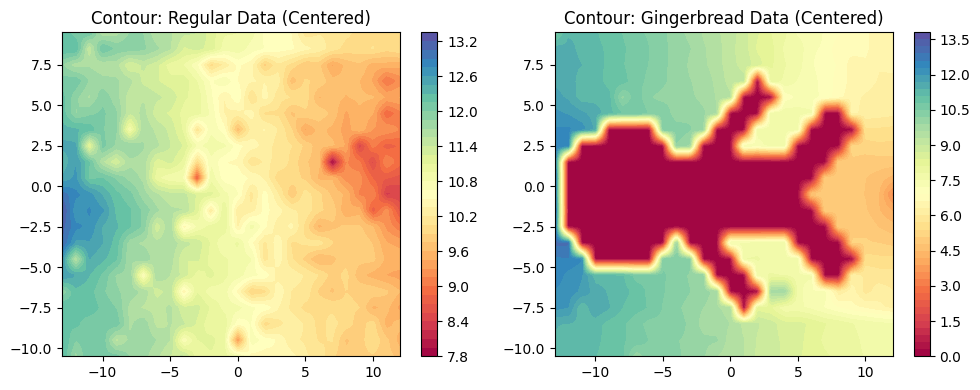

ValueError: One of the requested xi is out of bounds in dimension 0

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

########################
# 1. Data Loading & Interpolator
########################

def load_and_interpolate(filename):
    """
    Reads an Excel file, applies a vertical flip and transpose to match
    Mathematica’s Transpose[Reverse[data]] behavior, then creates an interpolator.
    The domain is centered so that (0,0) is the center.
    """
    df = pd.read_excel(filename, header=None)
    arr = np.flipud(df.values).T
    nx, ny = arr.shape
    # Create centered coordinate arrays
    x_vals = np.arange(nx) - (nx / 2.0)
    y_vals = np.arange(ny) - (ny / 2.0)
    interpolator = RegularGridInterpolator((x_vals, y_vals), arr, method='linear')
    return interpolator, (nx, ny), x_vals, y_vals

# File paths (adjust as needed)
regular_file = "/content/Regular.xlsx"
ginger_file  = "/content/Gingerbread.xlsx"

regular_interp, dims_reg, x_vals_reg, y_vals_reg = load_and_interpolate(regular_file)
ginger_interp, dims_ging, x_vals_ging, y_vals_ging = load_and_interpolate(ginger_file)

########################
# 2. Evaluation on a Grid
########################

def eval_on_grid(interp, x_vals, y_vals, N=200):
    """
    Evaluate the interpolation on a meshgrid that spans exactly the domain
    defined by x_vals and y_vals.
    """
    x_min, x_max = x_vals[0], x_vals[-1]
    y_min, y_max = y_vals[0], y_vals[-1]

    x_grid = np.linspace(x_min, x_max, N)
    y_grid = np.linspace(y_min, y_max, N)
    X, Y = np.meshgrid(x_grid, y_grid, indexing='xy')

    V = np.zeros_like(X)
    for i in range(N):
        for j in range(N):
            V[i, j] = interp((X[i, j], Y[i, j]))
    return X, Y, V

Xr, Yr, Vr = eval_on_grid(regular_interp, x_vals_reg, y_vals_reg, N=200)
Xg, Yg, Vg = eval_on_grid(ginger_interp, x_vals_ging, y_vals_ging, N=200)

########################
# 3. Contour Plots of Measured Data
########################

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
c1 = axes[0].contourf(Xr, Yr, Vr, levels=50, cmap='Spectral')
axes[0].set_title("Contour: Regular Data (Centered)")
fig.colorbar(c1, ax=axes[0])

c2 = axes[1].contourf(Xg, Yr, Vg, levels=50, cmap='Spectral')
axes[1].set_title("Contour: Gingerbread Data (Centered)")
fig.colorbar(c2, ax=axes[1])
plt.tight_layout()
plt.show()

########################
# 4. Stream Plots (Electric Field from Finite Differences)
########################

def compute_field(interp, x_vals, y_vals, N=30):
    """
    Compute the electric field (E = -grad(V)) using finite differences
    on a coarse grid that spans the valid domain.
    """
    x_min, x_max = x_vals[0], x_vals[-1]
    y_min, y_max = y_vals[0], y_vals[-1]
    x_grid = np.linspace(x_min, x_max, N)
    y_grid = np.linspace(y_min, y_max, N)
    X, Y = np.meshgrid(x_grid, y_grid, indexing='xy')

    dx = (x_max - x_min) / (N - 1)
    dy = (y_max - y_min) / (N - 1)

    Ex = np.zeros_like(X)
    Ey = np.zeros_like(X)

    for i in range(N):
        for j in range(N):
            x = X[i, j]
            y = Y[i, j]
            Vxp = interp((x + dx, y))
            Vxm = interp((x - dx, y))
            Vyp = interp((x, y + dy))
            Vym = interp((x, y - dy))
            dVdx = (Vxp - Vxm) / (2*dx)
            dVdy = (Vyp - Vym) / (2*dy)
            Ex[i, j] = -dVdx
            Ey[i, j] = -dVdy
    return X, Y, Ex, Ey

Xr_s, Yr_s, Exr, Eyr = compute_field(regular_interp, x_vals_reg, y_vals_reg, N=30)
Xg_s, Yg_s, Exg, Eyg = compute_field(ginger_interp, x_vals_ging, y_vals_ging, N=30)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].streamplot(Xr_s, Yr_s, Exr, Eyr, color='k', density=1, arrowsize=1)
axes[0].set_title("StreamPlot: Regular Data (Centered)")

axes[1].streamplot(Xg_s, Yg_s, Exg, Eyg, color='k', density=1, arrowsize=1)
axes[1].set_title("StreamPlot: Gingerbread Data (Centered)")
plt.tight_layout()
plt.show()

########################
# 5. Theoretical Expression (Centered Coordinates)
########################

def V_theoretical(x, y, a, Q=1, eps0=1):
    """
    Theoretical voltage expression for a dipole-like system:
      V = (Q/(4*pi*eps0)) * log(((x+a)**2+y**2)/((x-a)**2+y**2))
    """
    return (Q / (4.0 * np.pi * eps0)) * np.log(((x+a)**2 + y**2)/((x-a)**2 + y**2))

# For the theoretical model, use Regular data dimensions.
nx_reg, ny_reg = dims_reg
# Define 'a' as half the sheet width (in centered coordinates, this is at x = ±a)
a = (nx_reg / 2.0)  # adjust as appropriate

N_theory = 200
x_min, x_max = x_vals_reg[0], x_vals_reg[-1]
y_min, y_max = y_vals_reg[0], y_vals_reg[-1]
x_grid = np.linspace(x_min, x_max, N_theory)
y_grid = np.linspace(y_min, y_max, N_theory)
Xth, Yth = np.meshgrid(x_grid, y_grid, indexing='xy')
Vth = V_theoretical(Xth, Yth, a=a, Q=1, eps0=1)

# Contour plot of the theoretical voltage
fig, ax = plt.subplots(figsize=(6,5))
cs = ax.contourf(Xth, Yth, Vth, levels=50, cmap='Spectral')
fig.colorbar(cs, ax=ax)
ax.set_title("Theoretical Voltage (Centered)")
plt.show()

# Theoretical Electric Field (analytical derivatives)
def E_theoretical(x, y, a, Q=1, eps0=1):
    """
    Compute the electric field E = -grad(V) for the theoretical voltage.
    """
    denom = 4.0 * np.pi * eps0
    dVdx = (Q / denom) * (2*(x+a)/((x+a)**2 + y**2) - 2*(x-a)/((x-a)**2 + y**2))
    dVdy = (Q / denom) * (2*y/((x+a)**2 + y**2) - 2*y/((x-a)**2 + y**2))
    return -dVdx, -dVdy

# Compute the theoretical field on a coarse grid for streamplot
N_stream_theory = 30
x_s = np.linspace(x_min, x_max, N_stream_theory)
y_s = np.linspace(y_min, y_max, N_stream_theory)
Xs, Ys = np.meshgrid(x_s, y_s, indexing='xy')

Ex_th = np.zeros_like(Xs)
Ey_th = np.zeros_like(Xs)
for i in range(N_stream_theory):
    for j in range(N_stream_theory):
        Ex_th[i, j], Ey_th[i, j] = E_theoretical(Xs[i,j], Ys[i,j], a=a, Q=1, eps0=1)

fig, ax = plt.subplots(figsize=(6,5))
ax.streamplot(Xs, Ys, Ex_th, Ey_th, color='k', density=1, arrowsize=1)
ax.set_title("Theoretical Electric Field (Centered)")
plt.show()


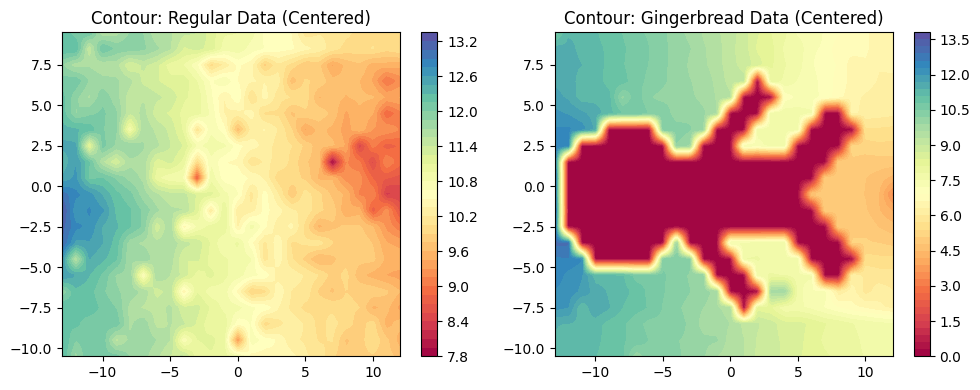

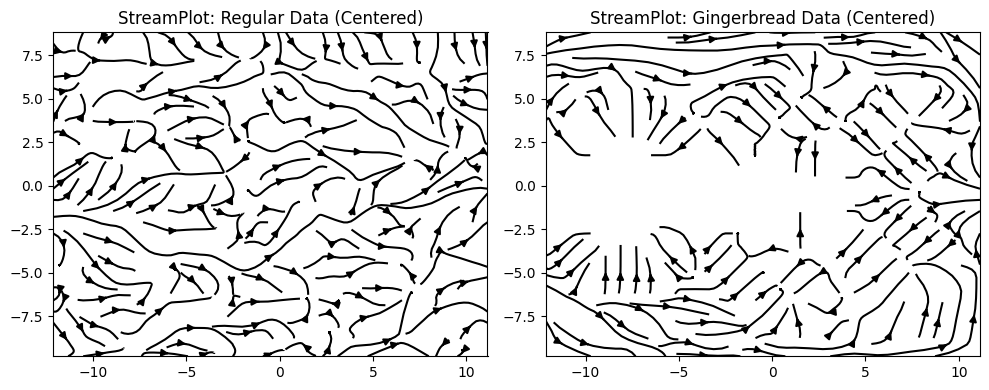

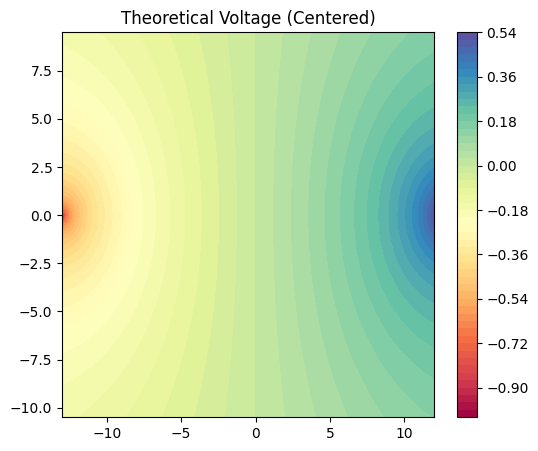

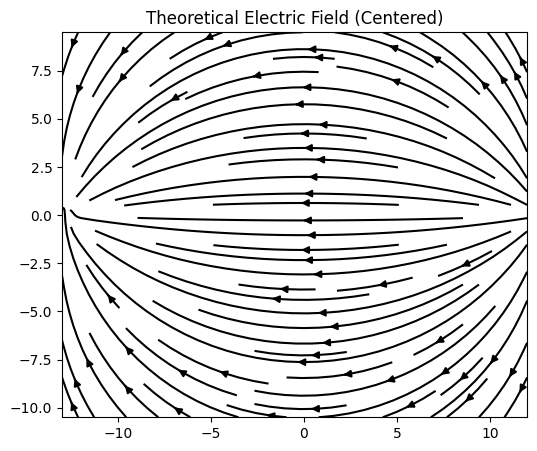

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

########################
# 1. Data Loading & Interpolator
########################

def load_and_interpolate(filename):
    """
    Reads an Excel file, applies a vertical flip and transpose to match
    Mathematica’s Transpose[Reverse[data]] behavior, then creates an interpolator.
    The domain is centered so that (0,0) is the center.
    """
    df = pd.read_excel(filename, header=None)
    arr = np.flipud(df.values).T
    nx, ny = arr.shape
    # Create centered coordinate arrays
    x_vals = np.arange(nx) - (nx / 2.0)
    y_vals = np.arange(ny) - (ny / 2.0)
    interpolator = RegularGridInterpolator((x_vals, y_vals), arr, method='linear')
    return interpolator, (nx, ny), x_vals, y_vals

# File paths (adjust as needed)
regular_file = "/content/Regular.xlsx"
ginger_file  = "/content/Gingerbread.xlsx"

regular_interp, dims_reg, x_vals_reg, y_vals_reg = load_and_interpolate(regular_file)
ginger_interp, dims_ging, x_vals_ging, y_vals_ging = load_and_interpolate(ginger_file)

########################
# 2. Evaluation on a Grid
########################

def eval_on_grid(interp, x_vals, y_vals, N=200):
    """
    Evaluate the interpolation on a meshgrid that spans exactly the domain
    defined by x_vals and y_vals.
    """
    x_min, x_max = x_vals[0], x_vals[-1]
    y_min, y_max = y_vals[0], y_vals[-1]

    x_grid = np.linspace(x_min, x_max, N)
    y_grid = np.linspace(y_min, y_max, N)
    X, Y = np.meshgrid(x_grid, y_grid, indexing='xy')

    V = np.zeros_like(X)
    for i in range(N):
        for j in range(N):
            V[i, j] = interp((X[i, j], Y[i, j]))
    return X, Y, V

Xr, Yr, Vr = eval_on_grid(regular_interp, x_vals_reg, y_vals_reg, N=200)
Xg, Yg, Vg = eval_on_grid(ginger_interp, x_vals_ging, y_vals_ging, N=200)

########################
# 3. Contour Plots of Measured Data
########################

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
c1 = axes[0].contourf(Xr, Yr, Vr, levels=50, cmap='Spectral')
axes[0].set_title("Contour: Regular Data (Centered)")
fig.colorbar(c1, ax=axes[0])

c2 = axes[1].contourf(Xg, Yg, Vg, levels=50, cmap='Spectral')
axes[1].set_title("Contour: Gingerbread Data (Centered)")
fig.colorbar(c2, ax=axes[1])
plt.tight_layout()
plt.show()

########################
# 4. Stream Plots (Electric Field from Finite Differences)
########################

def compute_field(interp, x_vals, y_vals, N=30):
    """
    Compute the electric field (E = -grad(V)) using finite differences
    on a grid that spans the valid domain with a margin to avoid boundary issues.
    """
    x_min, x_max = x_vals[0], x_vals[-1]
    y_min, y_max = y_vals[0], y_vals[-1]
    # Define a margin equal to one grid spacing on full domain if it were N points
    margin_x = (x_max - x_min) / (N - 1)
    margin_y = (y_max - y_min) / (N - 1)
    x_grid = np.linspace(x_min + margin_x, x_max - margin_x, N)
    y_grid = np.linspace(y_min + margin_y, y_max - margin_y, N)
    X, Y = np.meshgrid(x_grid, y_grid, indexing='xy')

    # Now, dx and dy are computed on this grid
    dx = (x_grid[-1] - x_grid[0]) / (N - 1)
    dy = (y_grid[-1] - y_grid[0]) / (N - 1)

    Ex = np.zeros_like(X)
    Ey = np.zeros_like(X)

    for i in range(N):
        for j in range(N):
            x = X[i, j]
            y = Y[i, j]
            Vxp = interp((x + dx, y))
            Vxm = interp((x - dx, y))
            Vyp = interp((x, y + dy))
            Vym = interp((x, y - dy))
            dVdx = (Vxp - Vxm) / (2 * dx)
            dVdy = (Vyp - Vym) / (2 * dy)
            Ex[i, j] = -dVdx
            Ey[i, j] = -dVdy
    return X, Y, Ex, Ey

Xr_s, Yr_s, Exr, Eyr = compute_field(regular_interp, x_vals_reg, y_vals_reg, N=30)
Xg_s, Yg_s, Exg, Eyg = compute_field(ginger_interp, x_vals_ging, y_vals_ging, N=30)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].streamplot(Xr_s, Yr_s, Exr, Eyr, color='k', density=1, arrowsize=1)
axes[0].set_title("StreamPlot: Regular Data (Centered)")

axes[1].streamplot(Xg_s, Yg_s, Exg, Eyg, color='k', density=1, arrowsize=1)
axes[1].set_title("StreamPlot: Gingerbread Data (Centered)")
plt.tight_layout()
plt.show()

########################
# 5. Theoretical Expression (Centered Coordinates)
########################

def V_theoretical(x, y, a, Q=1, eps0=1):
    """
    Theoretical voltage expression for a dipole-like system:
      V = (Q/(4*pi*eps0)) * log(((x+a)**2+y**2)/((x-a)**2+y**2))
    """
    return (Q / (4.0 * np.pi * eps0)) * np.log(((x+a)**2 + y**2)/((x-a)**2 + y**2))

# For the theoretical model, use Regular data dimensions.
nx_reg, ny_reg = dims_reg
# Define 'a' as half the sheet width (in centered coordinates, this is at x = ±a)
a = (nx_reg / 2.0)

N_theory = 200
x_min, x_max = x_vals_reg[0], x_vals_reg[-1]
y_min, y_max = y_vals_reg[0], y_vals_reg[-1]
x_grid = np.linspace(x_min, x_max, N_theory)
y_grid = np.linspace(y_min, y_max, N_theory)
Xth, Yth = np.meshgrid(x_grid, y_grid, indexing='xy')
Vth = V_theoretical(Xth, Yth, a=a, Q=1, eps0=1)

# Contour plot of the theoretical voltage
fig, ax = plt.subplots(figsize=(6, 5))
cs = ax.contourf(Xth, Yth, Vth, levels=50, cmap='Spectral')
fig.colorbar(cs, ax=ax)
ax.set_title("Theoretical Voltage (Centered)")
plt.show()

# Theoretical Electric Field (analytical derivatives)
def E_theoretical(x, y, a, Q=1, eps0=1):
    """
    Compute the electric field E = -grad(V) for the theoretical voltage.
    """
    denom = 4.0 * np.pi * eps0
    dVdx = (Q / denom) * (2*(x+a)/((x+a)**2 + y**2) - 2*(x-a)/((x-a)**2 + y**2))
    dVdy = (Q / denom) * (2*y/((x+a)**2 + y**2) - 2*y/((x-a)**2 + y**2))
    return -dVdx, -dVdy

# Compute the theoretical field on a coarse grid for streamplot
N_stream_theory = 30
x_s = np.linspace(x_min, x_max, N_stream_theory)
y_s = np.linspace(y_min, y_max, N_stream_theory)
Xs, Ys = np.meshgrid(x_s, y_s, indexing='xy')

Ex_th = np.zeros_like(Xs)
Ey_th = np.zeros_like(Xs)
for i in range(N_stream_theory):
    for j in range(N_stream_theory):
        Ex_th[i, j], Ey_th[i, j] = E_theoretical(Xs[i, j], Ys[i, j], a=a, Q=1, eps0=1)

fig, ax = plt.subplots(figsize=(6, 5))
ax.streamplot(Xs, Ys, Ex_th, Ey_th, color='k', density=1, arrowsize=1)
ax.set_title("Theoretical Electric Field (Centered)")
plt.show()

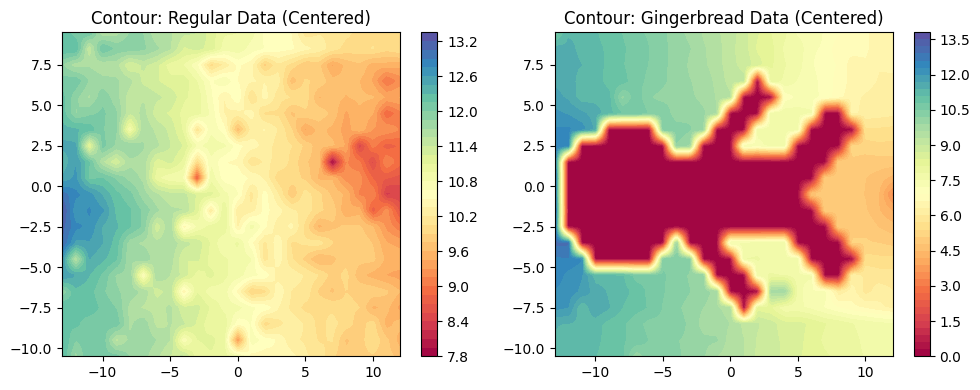

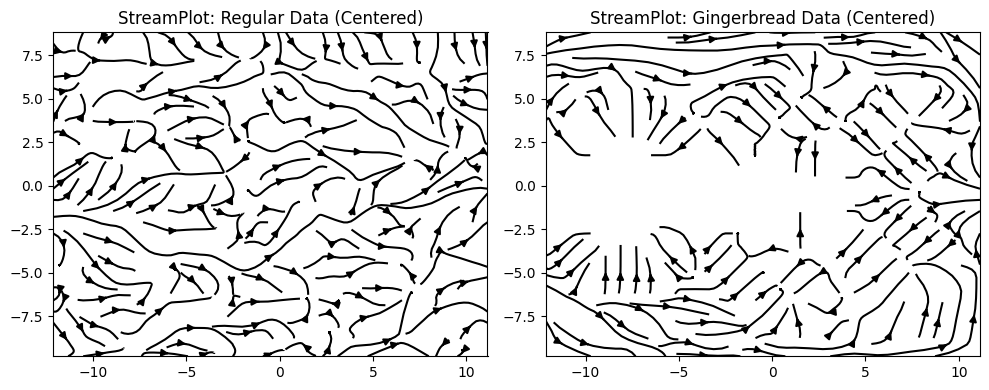

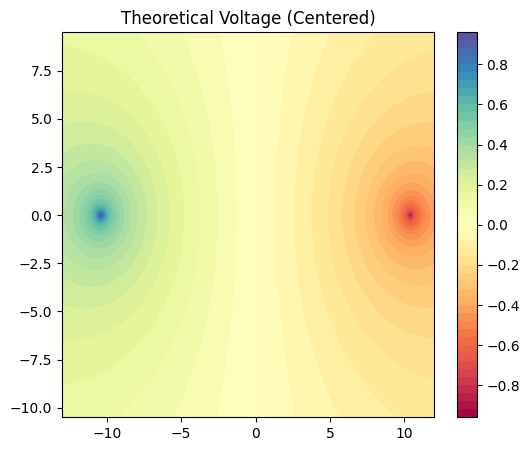

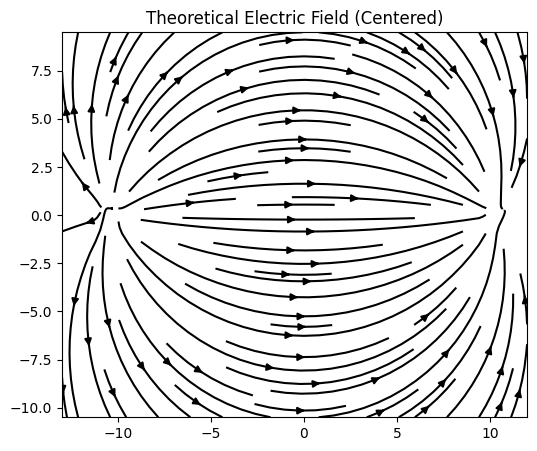

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

########################
# 1. Data Loading & Interpolator
########################

def load_and_interpolate(filename):
    """
    Reads an Excel file, applies a vertical flip and transpose (to mimic
    Mathematica’s Transpose[Reverse[data]]), and creates an interpolator.
    The domain is centered so that (0,0) is the center.
    """
    df = pd.read_excel(filename, header=None)
    arr = np.flipud(df.values).T
    nx, ny = arr.shape
    # Centered coordinates: x in [ -nx/2, ..., nx/2 ]
    x_vals = np.arange(nx) - (nx / 2.0)
    y_vals = np.arange(ny) - (ny / 2.0)
    interpolator = RegularGridInterpolator((x_vals, y_vals), arr, method='linear')
    return interpolator, (nx, ny), x_vals, y_vals

# File paths (adjust as needed)
regular_file = "/content/Regular.xlsx"
ginger_file  = "/content/Gingerbread.xlsx"

regular_interp, dims_reg, x_vals_reg, y_vals_reg = load_and_interpolate(regular_file)
ginger_interp, dims_ging, x_vals_ging, y_vals_ging = load_and_interpolate(ginger_file)

########################
# 2. Evaluation on a Grid
########################

def eval_on_grid(interp, x_vals, y_vals, N=200):
    """
    Evaluate the interpolation on a meshgrid spanning the domain defined by x_vals and y_vals.
    """
    x_min, x_max = x_vals[0], x_vals[-1]
    y_min, y_max = y_vals[0], y_vals[-1]

    x_grid = np.linspace(x_min, x_max, N)
    y_grid = np.linspace(y_min, y_max, N)
    X, Y = np.meshgrid(x_grid, y_grid, indexing='xy')

    V = np.zeros_like(X)
    for i in range(N):
        for j in range(N):
            V[i, j] = interp((X[i, j], Y[i, j]))
    return X, Y, V

Xr, Yr, Vr = eval_on_grid(regular_interp, x_vals_reg, y_vals_reg, N=200)
Xg, Yg, Vg = eval_on_grid(ginger_interp, x_vals_ging, y_vals_ging, N=200)

########################
# 3. Contour Plots of Measured Data
########################

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
c1 = axes[0].contourf(Xr, Yr, Vr, levels=50, cmap='Spectral')
axes[0].set_title("Contour: Regular Data (Centered)")
fig.colorbar(c1, ax=axes[0])

c2 = axes[1].contourf(Xg, Yr, Vg, levels=50, cmap='Spectral')
axes[1].set_title("Contour: Gingerbread Data (Centered)")
fig.colorbar(c2, ax=axes[1])
plt.tight_layout()
plt.show()

########################
# 4. Stream Plots (Electric Field from Finite Differences)
########################

def compute_field(interp, x_vals, y_vals, N=30):
    """
    Compute the electric field (E = -grad(V)) using finite differences on a grid
    with a margin so that (x±dx, y±dy) remain in bounds.
    """
    x_min, x_max = x_vals[0], x_vals[-1]
    y_min, y_max = y_vals[0], y_vals[-1]
    # Margin: one grid spacing on the N-point grid
    margin_x = (x_max - x_min) / (N - 1)
    margin_y = (y_max - y_min) / (N - 1)
    x_grid = np.linspace(x_min + margin_x, x_max - margin_x, N)
    y_grid = np.linspace(y_min + margin_y, y_max - margin_y, N)
    X, Y = np.meshgrid(x_grid, y_grid, indexing='xy')

    dx = (x_grid[-1] - x_grid[0]) / (N - 1)
    dy = (y_grid[-1] - y_grid[0]) / (N - 1)

    Ex = np.zeros_like(X)
    Ey = np.zeros_like(X)

    for i in range(N):
        for j in range(N):
            x = X[i, j]
            y = Y[i, j]
            Vxp = interp((x + dx, y))
            Vxm = interp((x - dx, y))
            Vyp = interp((x, y + dy))
            Vym = interp((x, y - dy))
            dVdx = (Vxp - Vxm) / (2 * dx)
            dVdy = (Vyp - Vym) / (2 * dy)
            Ex[i, j] = -dVdx
            Ey[i, j] = -dVdy
    return X, Y, Ex, Ey

Xr_s, Yr_s, Exr, Eyr = compute_field(regular_interp, x_vals_reg, y_vals_reg, N=30)
Xg_s, Yg_s, Exg, Eyg = compute_field(ginger_interp, x_vals_ging, y_vals_ging, N=30)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].streamplot(Xr_s, Yr_s, Exr, Eyr, color='k', density=1, arrowsize=1)
axes[0].set_title("StreamPlot: Regular Data (Centered)")
axes[1].streamplot(Xg_s, Yg_s, Exg, Eyg, color='k', density=1, arrowsize=1)
axes[1].set_title("StreamPlot: Gingerbread Data (Centered)")
plt.tight_layout()
plt.show()

########################
# 5. Corrected Theoretical Expression (Centered Coordinates)
########################

def V_theoretical(x, y, a, Q=1, eps0=1):
    """
    Theoretical voltage for two infinite rods (line charges) with:
      - Positive rod at x = -a
      - Negative rod at x = +a
    and with V(0,0)=0.

    Derived as:
      V(x,y) = - (Q/(4π ε₀)) ln [ ((x+a)²+y²) / ((x-a)²+y²) ]
    This ensures a positive potential near the positive rod (x = -a)
    and a negative potential near the negative rod (x = +a).
    """
    return - (Q/(4.0*np.pi*eps0)) * np.log(((x+a)**2 + y**2) / ((x-a)**2 + y**2))

# Choose 'a' appropriately. (For example, a can be set to a fraction of the half-width.)
nx_reg, ny_reg = dims_reg
# If the domain is x in [ -nx_reg/2, nx_reg/2 ], a might be chosen as:
a = (nx_reg / 2.0) * 0.8  # 80% of half-width, adjust as needed

N_theory = 200
x_min, x_max = x_vals_reg[0], x_vals_reg[-1]
y_min, y_max = y_vals_reg[0], y_vals_reg[-1]
x_grid = np.linspace(x_min, x_max, N_theory)
y_grid = np.linspace(y_min, y_max, N_theory)
Xth, Yth = np.meshgrid(x_grid, y_grid, indexing='xy')
Vth = V_theoretical(Xth, Yth, a=a, Q=1, eps0=1)

fig, ax = plt.subplots(figsize=(6, 5))
cs = ax.contourf(Xth, Yth, Vth, levels=50, cmap='Spectral')
fig.colorbar(cs, ax=ax)
ax.set_title("Theoretical Voltage (Centered)")
plt.show()

def E_theoretical(x, y, a, Q=1, eps0=1):
    """
    Analytical electric field for the theoretical voltage.
    With
      V(x,y) = - (Q/(4π ε₀)) ln [ ((x+a)²+y²) / ((x-a)²+y²) ],
    the field is:
      E_x =  (Q/(4π ε₀)) [ 2(x+a)/((x+a)²+y²) - 2(x-a)/((x-a)²+y²) ]
      E_y =  (Q/(4π ε₀)) [ 2y/((x+a)²+y²) - 2y/((x-a)²+y²) ]
    """
    factor = Q/(4.0*np.pi*eps0)
    Ex = factor * (2*(x+a)/((x+a)**2 + y**2) - 2*(x-a)/((x-a)**2 + y**2))
    Ey = factor * (2*y/((x+a)**2 + y**2) - 2*y/((x-a)**2 + y**2))
    return Ex, Ey

N_stream_theory = 30
x_s = np.linspace(x_min, x_max, N_stream_theory)
y_s = np.linspace(y_min, y_max, N_stream_theory)
Xs, Ys = np.meshgrid(x_s, y_s, indexing='xy')

Ex_th = np.zeros_like(Xs)
Ey_th = np.zeros_like(Xs)
for i in range(N_stream_theory):
    for j in range(N_stream_theory):
        Ex_th[i, j], Ey_th[i, j] = E_theoretical(Xs[i, j], Ys[i, j], a=a, Q=1, eps0=1)

fig, ax = plt.subplots(figsize=(6, 5))
ax.streamplot(Xs, Ys, Ex_th, Ey_th, color='k', density=1, arrowsize=1)
ax.set_title("Theoretical Electric Field (Centered)")
plt.show()
